In [279]:
from sklearn.neighbors.kde import KernelDensity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## 1

In [280]:
data = pd.read_csv('data.csv', delimiter=',', header=0)


In [281]:
data.head()

,Date,Amount
0,25May2016,54241.35
1,29May2017,54008.83
2,30Jun2017,54008.82
3,05Jan2017,52704.37
4,23Feb2017,52704.36


In [282]:
data['day'] = [i[:2] for i in data['Date']]

data['year'] = [i[-4:] for i in data['Date']]
data['month'] = [i[2:-4] for i in data['Date']]
data['month'] = pd.to_datetime(data['month'], format='%b').dt.month


In [283]:
data.head()

,Date,Amount,day,month,year
0,25May2016,54241.35,25,5,2016
1,29May2017,54008.83,29,5,2017
2,30Jun2017,54008.82,30,6,2017
3,05Jan2017,52704.37,05,1,2017
4,23Feb2017,52704.36,23,2,2017


In [386]:
a_ym = data.groupby(['year','month']).count()
year_month = a_ym.iloc[:,1].values.tolist()


a_m = data.groupby(['month']).count()
month = a_m.iloc[:,1].values.tolist()

In [387]:
X_ym = np.array(year_month).reshape(-1,1)
X_m = np.array(month).reshape(-1,1)

In [316]:
d = 1
n = X.shape[1]
# bw = (n * (d + 2) / 4.)**(-1. / (d + 4)) # silverman
bw = n**(-1./(d+4)) # scott
# bw=2

In [388]:
kde = KernelDensity(kernel='gaussian', bandwidth=4)
kde.fit(X)

KernelDensity(algorithm='auto', atol=0, bandwidth=4, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

In [389]:
X_plot = np.linspace(0, 110, 1000)[:, np.newaxis]
log_dens = kde.score_samples(X_plot)

Text(0.5,1,'Gaussian Kernel Density')

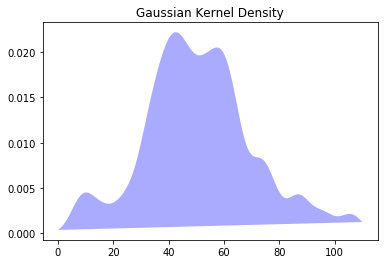

In [390]:
plt.fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
plt.title("Gaussian Kernel Density")


In [320]:
raw_samples = [kde.sample()for i in range(10)]
raw_samples

[array([[60.21770693]]),
 array([[60.38003633]]),
 array([[46.6051897]]),
 array([[7.30015169]]),
 array([[7.91930361]]),
 array([[77.71102316]]),
 array([[45.21794249]]),
 array([[35.43967845]]),
 array([[30.89905318]]),
 array([[43.04583744]])]

## 2

In [368]:
true_p_cluster = [0.4, 0.3, 0.15, 0.15]

n_questions = 20
n_people = 1000
n_clusters = len(true_p_cluster)

true_biases = np.random.beta(0.75, 0.75, size=(n_questions, n_clusters))
true_people = np.random.choice(range(n_clusters), size=n_people, p=true_p_cluster)

answers = np.zeros((n_people, n_questions), dtype=bool)

for a in range(n_people):
    cluster = true_people[a]
    answers[a, :] = np.random.rand(n_questions) < true_biases[:, cluster]

print(people)

np.savetxt("questionnaire.csv", answers, delimiter=",", fmt="%d")
np.savetxt("questionnaire_answers.csv", true_people, delimiter=",", fmt="%d")
np.savetxt("questionnaire_biases.csv", true_biases, delimiter=",", fmt="%.3f")

[[6.97033681e-01 5.76690809e-03 3.32568875e-04 2.96866842e-01]
 [1.13060910e-02 8.73976858e-01 1.08899680e-01 5.81737092e-03]
 [4.13126497e-01 2.27056426e-04 4.63468728e-03 5.82011759e-01]
 ...
 [8.45915196e-01 3.57434462e-03 3.77057660e-04 1.50133402e-01]
 [6.51247847e-03 2.52651677e-01 7.38811615e-01 2.02422933e-03]
 [8.89217613e-05 9.99737412e-01 1.73472156e-04 1.94071590e-07]]


In [369]:
# v - answer
# h - cluster/ assignment


answers = np.loadtxt("questionnaire.csv", delimiter=",") # binary matrix of 1000ppl*20qtestions 
n_people, n_questions = answers.shape 
n_clusters = 4

p_clusters = np.asarray([0.25, 0.25, 0.25, 0.25]) # vector of 1*4
biases = np.random.beta(0.75, 0.75, size=(n_questions, n_clusters)) # matrix of 20 by 4.


def expectation(answers, biases, p_clusters, people):
    # In this function we create our expectations.

    # This is probably not the correct answer!
    people = np.zeros((n_people, n_clusters))
    
    for person in range(n_people):
        person_answers = answers[person]
        
        for cluster in range(n_clusters):
            
            p_cluster_given_answer =  1 # multiply all probabilities for each questions 
            p_cluster_given_answer =  p_clusters[cluster] #prior
            
            for question_i, answer in enumerate(person_answers):
                
                # join probability of cluster given observed answers
                p_cluster_given_answer *= ( answer*biases[question_i, cluster] + (1-answer)*(1- biases[question_i, cluster]))
            
            
            people[person, cluster] = p_cluster_given_answer
            
        
    # normalize the distributions
    people = people / people.sum(axis=1, keepdims=1)
    
    return people


def maximization(answers, people, p_clusters, biases):
    # Treating all the data as visible, now infer the parameters for the model.
    
    # maximizing the p_of_answers_given_cluster
    for question in range(n_questions):
        for cluster in range(n_clusters):
            
            weighted_num = 0
            weighted_denum = 0
        
            for person in range(n_people):
            
                weighted_num +=  people[person, cluster] * answers[person, question] # bias*answer (will add only the ones)
                weighted_denum +=  people[person, cluster] # bias(will add both zeros and ones)
            
            p_of_answers_given_cluster = weighted_num/float(weighted_denum)
            biases[question, cluster] = p_of_answers_given_cluster
            
    # maximizing the priors       
    
    per_cluster_sum = np.zeros(4)
    
    for cluster in range(n_clusters):
        for person in range(n_people):
            
             per_cluster_sum[cluster] += people[person, cluster]
            
    total_sum = np.sum(per_cluster_sum)
    
    p_clusters = per_cluster_sum/total_sum 
    
    return biases, p_clusters


for step in range(10):
    people = expectation(answers, biases, p_clusters, people)
    biases, p_clusters = maximization(answers, people, p_clusters, biases)

# print(biases)
# print (true_biases)
print (p_clusters)
print (true_p_cluster)
# print(people)

# np.sum(people, axis=1)

[0.38750783 0.32061861 0.14881973 0.14305383]
[0.4, 0.3, 0.15, 0.15]


In [376]:
gap = np.abs (np.array(true_p_cluster)[true_people] - p_clusters[np.argmax(people, axis =1)])
np.unique(gap>0.05, return_counts=True)

(array([False,  True]), array([976,  24]))